<a href="https://colab.research.google.com/github/titocampos/estudo-crm/blob/master/Redes_Convolucionais_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aviso Legal
Este script sobre detecção automática de COVID-19 é apenas para fins educacionais. Não se destina a ser um sistema de diagnóstico confiável e altamente preciso do COVID-19, nem foi avaliado profissional ou academicamente.

Baseado no blog: https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/?__s=uwyrtqrb1sbk1eht5hsk 

Importando os pacotes necessários

In [1]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

TensorFlow 2.x selected.


Inicialize o taxa de apendizado, o numero de épocas e o tamanho do lote

In [0]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

Baixando o dataset de exemplo

In [0]:
!wget https://raw.githubusercontent.com/titocampos/estudo-crm/master/datasets/covid-19.zip;
!unzip ./covid-19.zip;
!rm -f ./covid-19.zip;

Para carregar nossos dados, pegamos todos os caminhos para as imagens no 
diretório do conjunto de dados. Então, para cada imagem vamos:
  - Extrair o rótulo da classe (covid ou normal).
  - Carregar a imagem e pré-processá-la convertendo para RGB e redimensionando-a para 224×224 pixels.
  - Atualizar nossas listas de dados e rotulos.
  - Escalonar as intensidades de pixel para o intervalo [0, 1] e converter nossos dados e rótulos para o formato de matriz NumPy.

In [0]:
imagePaths = list(paths.list_images("./dataset"))
data = []
labels = []

for imagePath in imagePaths:
	# Extrair o rótulo da classe do nome do arquivo
	label = imagePath.split(os.path.sep)[-2]
	# Carregue a imagem, troque canais de cores e redimensione-a para 224pxx224px, ignorando a proporção
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# atualizar as listas de dados e rótulos, respectivamente
	data.append(image)
	labels.append(label)
# Convert dados e rotulos para NumPy arrays, enquanto dimensiona as intensidades de pixel para o intervalo [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

Em seguida, codificaremos nossos rótulos de maneira única e criaremos nossas divisões de treinamento / teste.

Para garantir a generalização do nosso modelo, realizamos "data augmentation" definindo a rotação aleatória da imagem em 15 graus no sentido horário ou anti-horário.

In [0]:
# One-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); 

# Divisão do dataset em treinamento e teste, usando  80% para treinamento
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

# Data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

A partir daqui, inicializaremos nosso modelo VGGNet e o configuraremos para transfer learning.

In [0]:
# Carrega a rede VGG16, garantindo que a ultima camada seja deixados de fora
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# Construimos nosso modelo de cassificação
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# Mesclamos os 2 modelos para treinamento
model = Model(inputs=baseModel.input, outputs=headModel)
# Congelamos as camadas do modelo principal, para que eles *não* sejam atualizados durante o processo de treinamento
for layer in baseModel.layers:
	layer.trainable = False

Pronto. Agora é só compilar o modelo e treiná-lo.

In [14]:
# Compile o modelo
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# Inicie o treinamento
#H = model.fit()
H = model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 2s 375ms/step - loss: 0.2632 - accuracy: 0.9750 - val_loss: 0.2689 - val_accuracy: 0.7500
Epoch 2/25
5/5 [==============================] - 1s 171ms/step - loss: 0.3200 - accuracy: 0.9250 - val_loss: 0.2475 - val_accuracy: 0.7500
Epoch 3/25
5/5 [==============================] - 1s 169ms/step - loss: 0.2922 - accuracy: 0.9000 - val_loss: 0.2419 - val_accuracy: 0.8750
Epoch 4/25
5/5 [==============================] - 1s 163ms/step - loss: 0.2902 - accuracy: 0.9250 - val_loss: 0.2263 - val_accuracy: 0.8750
Epoch 5/25
5/5 [==============================] - 1s 165ms/step - loss: 0.2882 - accuracy: 0.9500 - val_loss: 0.2371 - val_accuracy: 0.7500
Epoch 6/25
5/5 [==============================] - 1s 172ms/step - loss: 0.2812 - accuracy: 0.9000 - val_loss: 0.2368 - val_accuracy: 0.7500
Epoch 7/25
5/5 [==============================] - 1s 166ms/step - loss: 0.2425 - accuracy: 0.

Para avaliação, primeiro fazemos previsões no conjunto de testes e obtemos os índices de previsão.

Em seguida, geramos e imprimimos um relatório de classificação usando o  scikit-learn.

In [15]:
# Faça predicoes no conjunto de testes
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.80      0.89         5
      normal       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



Gere uma matriz de confusão. Use a matriz de confusão para derivar a precisão, sensibilidade e especificidade e imprima cada uma dessas métricas.

In [16]:
# calcular a matriz de confusão e usá-la para derivar precisão, sensibilidade e especificidade
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [0 5]]
acc: 0.9000
sensitivity: 0.8000
specificity: 1.0000


Como você pode ver pelos resultados acima, nosso detector COVID-19 automático está obtendo ~ 80% de precisão em nosso conjunto de dados de amostra com base apenas em imagens de raios-X - nenhum outro dado.

Também estamos obtendo 60% de sensibilidade e 100% de especificidade, o que implica que:

  - Dos pacientes que possuem COVID-19 (ou seja, verdadeiros positivos), poderíamos identificá-los com precisão como "positivos para COVID-19" 60% do tempo usando nosso modelo.
  - Dos pacientes que não têm COVID-19 (ou seja, negativos verdadeiros), poderíamos identificá-los com precisão como "COVID-19 negativo" apenas 100% do tempo usando nosso modelo.

Em seguida, traçamos nosso histórico de precisão / perda de treinamento para inspeção

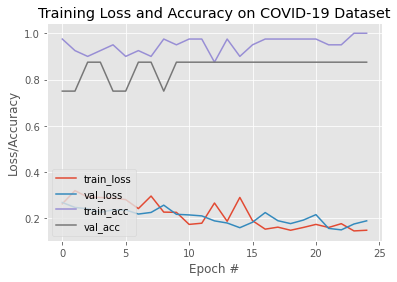

In [17]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Finalmente, serializamos nosso modelo de classificador tf.keras COVID-19 em disco

In [0]:
model.save("covid19.model", save_format="h5")